### Why improve loss_fn?

交叉熵损失函数并不直接优化`BLEU`, `ROUGE`, 或 `METEOR` 这些评价指标。

换句话说，即使模型在最小化交叉熵损失方面做得很好，也不一定意味着它在 `BLEU`, `ROUGE`, 或`METEOR`评分上会表现出色。这是因为这些指标衡量的是输出文本的整体质量，而交叉熵更多地关注于单个单词的正确预测。

为了解决这个不一致性问题，可以使用基于强化学习的方法。在这种方法中，你可以将`BLEU`, `ROUGE`, 或`METEOR`评分作为奖励信号，这样模型就不仅仅是学习预测正确的单词，而是直接朝着提高这些评价指标的方向优化。

这通常涉及到使用策略梯度方法，如REINFORCE算法，其中模型的输出（如一段文本）被视为一系列的“动作”，模型通过这些动作获得的评分（奖励）用来指导学习过程。

### 任务补充说明

在这里，我们选择`区域表示+自注意力`模型作为base model，基于此使用强化学习训练loss_fn, 并且使用这个loss_fn重新训练模型，测试在相关指标上的效果。

所以沿用之前的代码，在原代码的基础上做强化学习的更改，与训练逻辑的嵌入

首先导入必要的python包

注意：如果报错`缺失punkt`的话，把`nltk.download('punkt')`取消注释即可。

可能需要预先安装的包：

```bash
pip install vocabulary
pip install nltk
pip install -U requests                     # 这里是因为前面安装vocabulary包会导致requests起一些冲突，建议再安装一次
pip install rouge
```

In [35]:
import nltk
import os
import torch
import torch.utils.data as data
from vocabulary.vocabulary import Vocabulary
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt
import nltk
nltk.download('wordnet')
# nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 数据处理部分，分开处理训练集和测试集

In [19]:
%matplotlib inline
import os
import json
import random
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt

def create_dataset(dataset='deepfashion',
                   captions_per_image=1,
                   min_word_count=1,
                   max_len=80) -> str:
    """
    params:
        dataset: dataset path
        captions_per_image: captions amount for each image
        min_word_count: the minimum word count threshold
        max_len: max length of caption
    output:
        vocab.json
        train_data.json, val_data.json, test_data.json
    """ 
    train_data_json_path = '../dataset/deepfashion-multimodal/train_captions.json'
    test_data_json_path = '../dataset/deepfashion-multimodal/test_captions.json'
    image_folder = '../dataset/deepfashion-multimodal/images/'
    output_folder = '../output/' 
    
    # add additional check to avoid wasting time on processing dataset.
    if os.path.exists(output_folder):
        files = os.listdir(output_folder)
        if 'vocab.json' in files and 'train_data.json' in files and 'test_data.json' in files:
            print('Dataset already exists. Skipping processing.')
            return output_folder
    else:
        os.makedirs(output_folder)

    with open(train_data_json_path, 'r') as j:
        data = json.load(j)

    image_paths = []
    image_captions = []
    vocab = Counter()
    # push the captions into vocab
    for k,v in data.items():
        tokens = nltk.tokenize.word_tokenize(v.lower())
        vocab.update(tokens)
        path = os.path.join(image_folder,k)
        image_paths.append(path)
        if len(tokens) <= max_len:
            image_captions.append(tokens)
        elif len(tokens) > max_len:
            tokens=tokens[0:max_len]
            image_captions.append(tokens)
        if len(tokens) == 0:
            continue

    # create vocab
    words = [w for w in vocab.keys() if vocab[w] >= min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)

    # store vocab
    with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw)

    # clean up captions
    enc_captions = []
    for j, c in enumerate(image_captions):
        # encode the captions according to vocab
        enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']]
        enc_captions.append(enc_c)

    assert len(image_paths) * captions_per_image == len(enc_captions)

    for i, path in enumerate(image_paths):
        # check if the image can be resolved
        img = Image.open(path)

    
    data = {'IMAGES': image_paths,
            'CAPTIONS': enc_captions}
    with open(os.path.join(output_folder, 'train_data.json'), 'w') as fw:
        json.dump(data, fw)

    with open(test_data_json_path, 'r') as t:
        test_data = json.load(t)

    test_image_paths = []
    test_image_captions = []

    for k,v in test_data.items():
        tokens=nltk.tokenize.word_tokenize(v.lower())
        path = os.path.join(image_folder,k)
        test_image_paths.append(path)
        if len(tokens) <= max_len:
            test_image_captions.append(tokens)
        elif len(tokens) > max_len :
            tokens=tokens[0:max_len]
            test_image_captions.append(tokens)
        if len(tokens) == 0:
            continue

    test_enc_captions = []
    for j, c in enumerate(test_image_captions):
        enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']]
        test_enc_captions.append(enc_c)


    assert len(image_paths) * captions_per_image == len(enc_captions)

    for i, path in enumerate(image_paths):
        img = Image.open(path)

    testdata = {'IMAGES': test_image_paths,
            'CAPTIONS': test_enc_captions}
    with open(os.path.join(output_folder, 'test_data.json'), 'w') as fw:
        json.dump(testdata, fw)
        
    return output_folder
output_folder = create_dataset()

Dataset already exists. Skipping processing.


对上方的数据集初步处理结果进行简单的验证

具体验证思路仿造案例：

随机读取图像、查看图像，查看图像对应的caption

[107, 1, 24, 26, 33, 69, 40, 29, 11, 12, 13, 14, 1, 40, 18, 29, 8, 9, 14, 17, 4, 33, 65, 15, 14, 1, 24, 26, 33, 5, 50, 14, 1, 50, 47, 29, 8, 9, 10, 58, 12, 13, 14, 51, 18, 27, 53, 35, 36, 54, 14, 23, 24, 18, 32, 33, 34, 35, 36, 37, 14, 108]
<start> the lady wears a short-sleeve shirt with solid color patterns . the shirt is with cotton fabric . it has a lapel neckline . the lady wears a long trousers . the trousers are with cotton fabric and pure color patterns . there is an accessory on her wrist . this lady is wearing a ring on her finger . <end>


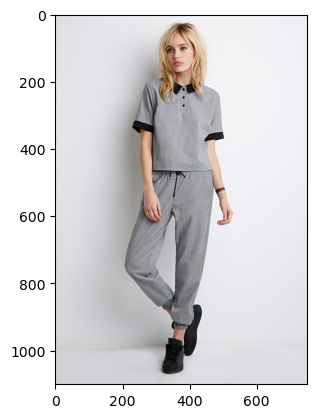

In [20]:
# read vocab and datas
with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open(os.path.join(output_folder, 'train_data.json'), 'r') as f:
    data = json.load(f)
with open(os.path.join(output_folder, 'test_data.json'), 'r') as k:
    testdata = json.load(k)

# show the 20th data
# show image
content_img = Image.open(data['IMAGES'][20])
plt.imshow(content_img)

# show token_ids and tokens
print(data['CAPTIONS'][20])
print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][20]]))

构建dataset类，便于后续dataloader的构建

在此处，我们创建`ImageCaption` 数据集，`getitem`内部函数返回三个值：

+ image: PIL.Image
+ caption: str
+ cap_len: int

In [21]:
from argparse import Namespace
import numpy as np
import os
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

class ImageCaptionDataset(Dataset):
    def __init__(self, 
                 dataset_path: str, 
                 vocab_path: str, 
                 split: str,    # the choice in {'train', 'test'}
                 captions_per_image: int=1, 
                 max_len: int=80, 
                 transform=None):
        self.split = split
        assert self.split in {'train', 'test'}
        self.cpi = captions_per_image
        self.max_len = max_len

        # load the json files
        with open(dataset_path, 'r') as f:
            self.data = json.load(f)
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        # process the images for further forward computing
        self.transform = transform

        # Total number of data points
        self.dataset_size = len(self.data['CAPTIONS'])

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        img = Image.open(self.data['IMAGES'][i]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        caplen = len(self.data['CAPTIONS'][i])
        caption = torch.LongTensor(self.data['CAPTIONS'][i]+ [self.vocab['<pad>']] * (self.max_len + 2 - caplen))

        return img, caption, caplen


    def __len__(self):
        return self.dataset_size

仿：定义`mktrainval`函数，返回train_dataloader和test_dataloader

这一步需要使用上方的`ImageCaptionDataset`类

In [22]:
def mktrainval(data_dir, vocab_path, batch_size, workers=4):
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_set = ImageCaptionDataset(os.path.join(data_dir, 'train_data.json'),
                                 vocab_path, 
                                 split='train',  
                                 transform=train_tx)
    test_set = ImageCaptionDataset(os.path.join(data_dir, 'test_data.json'),
                                 vocab_path, 
                                 split='test', 
                                 transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, test_loader


### 编码器的self attention部分，采用多头注意力实现，添加在resnet101网络后

In [23]:
import torch
import torch.nn as nn
import torchvision

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super(SelfAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=heads)
        
    def forward(self, feature_maps):
        """
        :param 
            feature_maps: torch.Tensor, shape (batch_size, channels, height, width)
            
        :return: torch.Tensor, shape (batch_size, channels, height, width)
        """
        
        # Reshape feature_maps to (batch_size, width*height, channels) for multihead attention
        batch_size, channels, height, width = feature_maps.size()
        feature_maps = feature_maps.permute(0, 2, 3, 1).reshape(batch_size, height * width, channels)
        # Calculate self-attention (it returns attn_output and attn_output_weights, but we need only the output)
        attn_output, _ = self.multihead_attn(feature_maps, feature_maps, feature_maps)
        # Reshape back to (batch_size, channels, height, width)
        attn_output = attn_output.reshape(batch_size, height, width, channels).permute(0, 3, 1, 2)
        return attn_output

从这里开始，基于前面的self-attention层，做一个基于注意力layer的encoder

In [24]:
# encoder for image, add attention layer
import torchvision.models as models
class ImageEncoder(nn.Module):
    def __init__(self, finetuned=True, heads=8, attn_embed_dim=2048):
        super(ImageEncoder, self).__init__()
        self.model = torchvision.models.resnet101(pretrained=True)  # we use pretrained ImageNet ResNet-101        
        self.grid_rep_extractor = nn.Sequential(*(list(self.model.children())[:-2]))    # ResNet Conv as grid extractor

        self.self_attention = SelfAttention(embed_dim=attn_embed_dim, heads=heads)
        
        for param in self.grid_rep_extractor.parameters():
            param.requires_grad = finetuned
            
    def forward(self, images):
        feature_maps = self.grid_rep_extractor(images)  # (batch_size, 2048, H, W)
        #feature_maps = self.additional_conv(feature_maps)  # (batch_size, attn_embed_dim, H, W)
        out = self.self_attention(feature_maps)
        return out

### 下面三块是解码器和整体网络搭建

In [25]:
class AdditiveAttention(nn.Module):
    def  __init__(self, query_dim, key_dim, attn_dim):
        super(AdditiveAttention, self).__init__()
        self.attn_w_1_q = nn.Linear(query_dim, attn_dim)
        self.attn_w_1_k = nn.Linear(key_dim, attn_dim)
        self.attn_w_2 = nn.Linear(attn_dim, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, query, key_value):
        """
        shape: 
            query: (batch_size, q_dim)  ===================> Q
            key_value: (batch_size, n_kv, kv_dim) =======> K, V
        """
        
        queries = self.attn_w_1_q(query).unsqueeze(1)               # -> (batch_size, 1, attn_dim)
        keys = self.attn_w_1_k(key_value)                           # -> (batch_size, n_kv, attn_dim)
        attn = self.attn_w_2(self.tanh(queries+keys)).squeeze(2)    # -> (batch_size, n_kv)
        # normalize weights
        attn = self.softmax(attn)                                   # -> (batch_size, n_kv)
        # get the attn output
        
        output = torch.bmm(attn.unsqueeze(1), key_value).squeeze(1) # -> (batch_size, 1, kv_dim)
        return output, attn

In [26]:
class AttentionDecoder(nn.Module):
    def __init__(self, feature_dim, vocab_size, word_dim, attention_dim, hidden_size, num_layers, dropout=0.5):
        super(AttentionDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, word_dim)
        self.attention = AdditiveAttention(hidden_size, feature_dim, attention_dim)
        self.init_state = nn.Linear(feature_dim, num_layers*hidden_size)
        self.rnn = nn.GRU(word_dim + feature_dim, hidden_size, num_layers)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, image_feature, captions, cap_lens):
        """
            image_feature: the image feature extracted by CNN, 
                            shape (batch_size, feature_dim, grid_height, grid_width)

        """
        # convert image_feature to (batch_size, feature_dim, grid_height*grid_width)
        batch_size, feature_dim = image_feature.size(0), image_feature.size(1)
        # switch the order of grid_height and grid_width
        image_feature = image_feature.permute(0, 2, 3, 1)
        # flatten the feature maps
        image_feature = image_feature.view(batch_size, -1, feature_dim)
        # sort the captions by their lengths
        sorted_cap_lens, sorted_cap_indices = torch.sort(cap_lens, 0, True)
        captions = captions[sorted_cap_indices]
        image_feature = image_feature[sorted_cap_indices]
        
        # get the initial hidden state
        hidden_state = self.init_state(image_feature.mean(axis=1))
        hidden_state = hidden_state.view(
                            batch_size,
                            self.rnn.num_layers,
                            self.rnn.hidden_size).permute(1, 0, 2)
        return image_feature, captions, sorted_cap_lens, sorted_cap_indices, hidden_state

    def forward_step(self, image_feature, curr_cap_embed, hidden_state):
        context, alpha = self.attention(hidden_state[-1], image_feature)
        # (1, real_batch_size, hidden_size+word_dim)
        x = torch.cat((context, curr_cap_embed), dim=-1).unsqueeze(0)
        # x: (1, real_batch_size, hidden_size+word_dim)
        # out: (1, real_batch_size, hidden_size)
        out, hidden_state = self.rnn(x, hidden_state)
        preds = self.fc(self.dropout(out.squeeze(0)))
        return preds, alpha, hidden_state

    def forward(self, image_feature, captions, cap_lens):
        """
            hidden_state: (num_layers, batch_size, hidden_size)
            image_feature:  (batch_size, feature_channel, feature_size)
            captions: (batch_size, )
        """
        image_feature, captions, sorted_cap_lens, sorted_cap_indices, hidden_state \
            = self.init_hidden_state(image_feature, captions, cap_lens)
        batch_size = image_feature.size(0)
        
        # notice: the input length -1, because we don't need to predict the last word
        lengths = sorted_cap_lens.cpu().numpy() - 1

        predictions = torch.zeros(batch_size, lengths[0], self.fc.out_features).to(captions.device)
        alphas = torch.zeros(batch_size, lengths[0], image_feature.shape[1]).to(captions.device)
        # cap_embeds: (batch_size, num_steps, word_dim)
        cap_embeds = self.embed(captions)
        
        # allocate for each image, the step stands for the time step
        for step in range(lengths[0]):
            real_batch_size = np.where(lengths>step)[0].shape[0]
            preds, alpha, hidden_state = self.forward_step(
                            image_feature[:real_batch_size],
                            cap_embeds[:real_batch_size, step, :],
                            hidden_state[:, :real_batch_size, :].contiguous())

            predictions[:real_batch_size, step, :] = preds
            alphas[:real_batch_size, step, :] = alpha
            
        """ARCTIC
            return:
                predictions: (batch_size, max_len, vocab_size)  [16, 74, 109]
                    16 是批次大小
                    74 对每个时间步长的输出
                    109 是词汇表的大小，即模型输出的每个时间步可能的单词数
                alphas: (batch_size, max_len, feature_size)     [16, 74, 49]
                    这可能是与注意力机制相关的输出。
                    16 是批次大小，
                    74 是序列长度，
                    49 可能代表每个时间步中注意力权重的数量或某种内部特征的维度。
                captions: (batch_size, max_len)                 [16, 82]
                lengths: (batch_size, )                         (16,)
                sorted_cap_indices: (batch_size, )              [16]
                    用于跟踪经过排序或处理的标注在原始数据集中的索引。
        """
        return predictions, alphas, captions, lengths, sorted_cap_indices

In [27]:
from typing import List

class ARCTIC(nn.Module):
    def __init__(self, image_code_dim, vocab, word_dim, attention_dim, hidden_size, num_layers):
        super(ARCTIC, self).__init__()
        self.vocab = vocab
        self.vocab_reverse = {idx:word for word,idx in self.vocab.items()}
        self.filtered_token = set({vocab['<pad>'], vocab['<start>'], vocab['<end>']})
        
        # net
        self.encoder = ImageEncoder()
        self.decoder = AttentionDecoder(image_code_dim, len(vocab), word_dim, attention_dim, hidden_size, num_layers)

    def forward(self, images, captions, cap_lens):
        image_code = self.encoder(images)
        return self.decoder(image_code, captions, cap_lens)

    def generate(self, images, beam_k, max_len):
        vocab_size = len(self.vocab)
        image_codes = self.encoder(images)
        texts = []
        device = images.device
        
        # beamsearch for each image
        for image_code in image_codes:
            gen_sent = self._beam_search(image_code, beam_k, max_len, vocab_size)   
            texts.append(gen_sent)
        return texts
    
    def generate_next_word(self, image_code, cur_sents, hidden_state, beam_k, vocab_size):
        preds, _, hidden_state = self.decoder.forward_step(image_code, cur_sents, hidden_state)
        preds = nn.functional.log_softmax(preds, dim=1)

        # 找到概率最高的单词
        topk_probs, topk_indices = preds.topk(beam_k, dim=1)

        return topk_indices, topk_probs, hidden_state
    
    def _beam_search(self, image_code, beam_k, max_len, vocab_size):
        """ _beam_search: get a sentence_ids
        this function generate a sentence_ids for a image_feature
        
        """
        # make `k` copies for a image
        image_code = image_code.unsqueeze(0).repeat(beam_k, 1, 1, 1)       #  (5，2048)
        # generate k sentences
        cur_sents = torch.full((beam_k, 1), self.vocab['<start>'], dtype=torch.long).to(device) # [k, 1] -> k sentence slots
        cur_sent_embed = self.decoder.embed(cur_sents)[:, 0, :]
        sent_lens = torch.LongTensor([1]*beam_k).to(device)

        image_code, cur_sent_embed, _, _, hidden_state = \
            self.decoder.init_hidden_state(image_code, cur_sent_embed, sent_lens)

        # store generated sentences
        end_sentences = []
        end_probs = []
        probs = torch.zeros(beam_k, 1).to(device)       # k slots, each slot has a prob
        k = beam_k
        while True:
            preds, _, hidden_state = self.decoder.forward_step(image_code[:k], cur_sent_embed, hidden_state.contiguous())
            preds = nn.functional.log_softmax(preds, dim=1) # get the log probability

            probs = probs.repeat(1, preds.size(1)) + preds
            if cur_sents.size(1) == 1:
                values, indices = probs[0].topk(k, 0, True, True)
            else:
                # convert to 1D
                values, indices = probs.view(-1).topk(k, 0, True, True)

            # now we have the top k candidates, with their probs value and indices
            sent_indices = torch.div(indices, vocab_size, rounding_mode='trunc')
            word_indices = indices % vocab_size

            cur_sents = torch.cat([cur_sents[sent_indices], word_indices.unsqueeze(1)], dim=1)

            end_indices = [idx for idx, word in enumerate(word_indices) if word == self.vocab['<end>']]
            if len(end_indices) > 0:
                end_probs.extend(values[end_indices])
                end_sentences.extend(cur_sents[end_indices].tolist())

                k -= len(end_indices)
                if k == 0:
                    break

            cur_indices = [idx for idx, word in enumerate(word_indices) if word != self.vocab['<end>']]
            
            # update the variables
            if len(cur_indices) > 0:
                cur_sent_indices = sent_indices[cur_indices]
                cur_word_indices = word_indices[cur_indices]

                cur_sents = cur_sents[cur_indices]
                
                probs = values[cur_indices].view(-1,1)
                hidden_state = hidden_state[:,cur_sent_indices,:]
                cur_sent_embed = self.decoder.embed(cur_word_indices.view(-1,1))[:,0,:]

            if cur_sents.size(1) >= max_len:
                break
            
            # loop end
        
        # get the generated sentence with the highest probability
        if len(end_sentences) == 0:
            generate_sentence = cur_sents[0].tolist()
        else:
            generate_sentence = end_sentences[end_probs.index(max(end_probs))]
            
        return generate_sentence
    
    def decode(self, token_ids) -> List[str]:
        return [self.vocab_reverse[token_id] for token_id in token_ids if token_id not in self.filtered_token]
    


In [28]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, predictions, targets, lengths):
        predictions = pack_padded_sequence(predictions, lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
        return self.loss_fn(predictions, targets)   # return a real loss object fn for backpropagation


In [29]:
def get_optimizer(model, config):
    return torch.optim.Adam([{"params": filter(lambda p: p.requires_grad, model.encoder.parameters()),
                              "lr": config.encoder_learning_rate},
                             {"params": filter(lambda p: p.requires_grad, model.decoder.parameters()),
                              "lr": config.decoder_learning_rate}])

def adjust_learning_rate(optimizer, epoch, config):
    optimizer.param_groups[0]['lr'] = config.encoder_learning_rate * (0.1 ** (epoch // config.lr_update))
    optimizer.param_groups[1]['lr'] = config.decoder_learning_rate * (0.1 ** (epoch // config.lr_update))

In [30]:
from nltk.translate.bleu_score import corpus_bleu

def filter_useless_words(sent, filterd_words):
    return [w for w in sent if w not in filterd_words]

def evaluate_belu4(data_loader, model, config, eval_rate=1.0):
    model.eval()
    cands = []
    refs = []
    filterd_words = set({model.vocab['<start>'], model.vocab['<end>'], model.vocab['<pad>']})
    cpi = config.captions_per_image
    device = next(model.parameters()).device
    eval_length = eval_rate * len(data_loader)
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        if i >= eval_length:
            break
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)
            cands.extend([filter_useless_words(text, filterd_words) for text in texts])
            refs.extend([filter_useless_words(cap, filterd_words) for cap in caps.tolist()])

    multiple_refs = []
    for idx in range(len(refs)):
        multiple_refs.append(refs[(idx//cpi)*cpi : (idx//cpi)*cpi+cpi])
        
    bleu4 = corpus_bleu(multiple_refs, cands, weights=(0.25,0.25,0.25,0.25))
    model.train()
    return bleu4

In [31]:
import json
import torch
from nltk.translate.meteor_score import single_meteor_score

def evaluate_meteor(data_loader, model, config, eval_rate=1.0):
    model.eval()
    cands = []
    refs = []
    filterd_words = set({'<start>', '<end>', '<pad>'})
    device = next(model.parameters()).device

    with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    eval_length = eval_rate * len(data_loader)

    for i, (imgs, caps, caplens) in enumerate(data_loader):
        if i >= eval_length:
            break
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)
            decoded_texts = [' '.join([vocab_idx2word[word_idx] for word_idx in text]) for text in texts]
            filtered_texts = [' '.join(filter_useless_words(text.split(), filterd_words)) for text in decoded_texts]
            cands.extend(filtered_texts)
            
            for cap in caps.tolist():
                decoded_cap = ' '.join([vocab_idx2word[word_idx] for word_idx in cap if word_idx in vocab_idx2word])
                filtered_cap = ' '.join(filter_useless_words(decoded_cap.split(), filterd_words))
                refs.append(filtered_cap)

    meteor_score = 0
    for cand, ref in zip(cands, refs):
        meteor_score += single_meteor_score(ref.split(), cand.split())

    meteor_score /= len(cands)
    model.train()
    return meteor_score

In [32]:
from rouge import Rouge

def evaluate_Rouge_L(data_loader, model, config, eval_rate=1.0):
    model.eval()
    cands = []
    refs = []
    decoded_caps = []
    filterd_words = set({'<start>', '<end>', '<pad>'})
    device = next(model.parameters()).device

    with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    eval_length = eval_rate * len(data_loader)

    for i, (imgs, caps, caplens) in enumerate(data_loader):
        if i >= eval_length:
            break
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)
            decoded_texts = [' '.join([vocab_idx2word[word_idx] for word_idx in text]) for text in texts]
            filtered_texts = [' '.join(filter_useless_words(text.split(), filterd_words)) for text in decoded_texts]
            cands.extend(filtered_texts)
            
            for cap in caps.tolist():
                decoded_cap = ' '.join([vocab_idx2word[word_idx] for word_idx in cap if word_idx in vocab_idx2word])
                filtered_cap = ' '.join(filter_useless_words(decoded_cap.split(), filterd_words))
                refs.append(filtered_cap)

    rouge_evaluator = Rouge(metrics=['rouge-l'])

    scores = rouge_evaluator.get_scores(cands, refs, avg=True) 
    rouge_l_score = scores['rouge-l']['f']  

    model.train()
    return rouge_l_score

### 训练部分逻辑：基于强化学习的损失函数

__强化学习损失函数的关键要素__

+ 定义奖励：你需要定义一个奖励函数，它基于你的评价指标（比如BLEU分数）。这个奖励将在每次生成文本后给出。

+ 策略网络：你的模型（现在作为策略网络）将生成动作（文本），并根据生成的文本的质量（通过奖励函数评估）来更新。

+ 策略梯度方法：你可以使用REINFORCE或其他策略梯度方法来更新模型。这里的关键是根据生成的文本的奖励来计算梯度，并据此更新模型权重。

在典型的强化学习场景中，几个关键要素是：

+ Agent（代理）：在你的情况下，代理是生成文本的模型本身。
+ Environment（环境）：环境通常是代理与之交互以获得反馈的系统。在文本生成中，这种反馈可以是基于生成文本的评估指标。
+ Action（动作）：动作是代理在给定状态下可以采取的决策。在你的模型中，动作是生成特定的单词或序列。
+ Policy（策略）：策略定义了代理如何基于当前状态选择动作。这通常是由模型的神经网络参数化的。
+ Reward（奖励）：奖励是代理根据其动作的效果获得的反馈，用于指导其学习。


在这里，我们针对METEOR指标，进行优化


In [33]:
from nltk.translate.meteor_score import single_meteor_score


def calculate_rewards(generated_ids: List[List[int]], 
                      reference_ids: List[List[int]], 
                      model):
    """
        The generated_texts, reference_texts can be the raw output of the model
    """
    cands = []
    refs = []
    filterd_words = set({model.vocab['<start>'], model.vocab['<end>'], model.vocab['<pad>']})
    cands.extend([filter_useless_words(text, filterd_words) for text in generated_ids])
    refs.extend([filter_useless_words(cap, filterd_words) for cap in reference_ids.tolist()])
    
    rewards = []
    
    assert len(cands) == len(refs), "The number of generated texts and reference texts should be the same."
    
    
    for gen_text, ref_text in zip(cands, refs):
        # 过滤无用的词
        filtered_gen_text = model.decode(gen_text)
        filtered_ref_text = model.decode(ref_text)

        # 计算每个句子的meteor分数
        bleu_score = single_meteor_score(filtered_ref_text, filtered_gen_text)
        rewards.append(bleu_score)

    return rewards

In [34]:
from tqdm import tqdm
import torch.nn.functional as F

# 设置模型超参数和辅助变量
config = Namespace(
    max_len = 80,
    captions_per_image = 1,
    batch_size = 16,
    image_code_dim = 2048,
    word_dim = 512,
    hidden_size = 512,
    attention_dim = 512,
    num_layers = 1,
    encoder_learning_rate = 0.001,
    decoder_learning_rate = 0.0005,
    num_epochs = 3,
    grad_clip = 5.0,
    alpha_weight = 1.0,
    evaluate_step = 300, 
    checkpoint = None, 
    beam_k = 5,
    scale_factor = 0.1,  # 你可以调整这个值，这是RL的缩放因子
    lr_update = 1,
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = output_folder
vocab_path = os.path.join(data_dir, 'vocab.json')
train_loader, test_loader = mktrainval(data_dir, vocab_path, config.batch_size)

sf_str = str(config.scale_factor).replace('.', '')

with open(vocab_path, 'r') as f:
    vocab = json.load(f)

start_epoch = 0
checkpoint = config.checkpoint
if checkpoint is None:
    model = ARCTIC(config.image_code_dim, vocab, config.word_dim, config.attention_dim, config.hidden_size, config.num_layers)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']

optimizer = get_optimizer(model, config)

model.to(device)
model.train()

loss_fn = CrossEntropyLoss().to(device)

ckpt_path = os.path.join(output_folder, 'model_ckpt/attn_rl')

if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)

best_res = 0
print("Start training")

vocab_reverse = {idx:word for word,idx in model.vocab.items()}

for epoch in range(start_epoch, config.num_epochs):
    print("Training on epoch ", epoch)
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{config.num_epochs}', unit='batch') as pbar:
        for i, (imgs, caps, caplens) in enumerate(train_loader):
            optimizer.zero_grad()

            imgs = imgs.to(device)      # [16, 3, 224, 224]
            caps = caps.to(device)      # [16, 82]
            caplens = caplens.to(device)
            

            # forward propagation
            predictions, alphas, sorted_captions, lengths, sorted_cap_indices = model(imgs, caps, caplens)
            
            # RL-learning
            gen_token_ids = model.generate(imgs, config.beam_k, config.max_len+2)
            
            # we adopt the reward function as meteor
            rewards = calculate_rewards(gen_token_ids, caps.cpu(), model)
            rewards = torch.tensor(rewards, dtype=torch.float).to(device)
            
            # normalize the rewards, to avoid the gradient explosion
            rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-9)
            
            # calculate the policy gradient loss
            # first we need to change shape
            if sorted_captions.size(1) > predictions.size(1):
                another_sorted_captions = sorted_captions[:, :predictions.size(1)]
            
            
            probabilities = F.softmax(predictions, dim=-1)
            target_probs = probabilities.gather(dim=-1, index=another_sorted_captions[:, 1:].unsqueeze(-1)).squeeze(-1)
            log_probs = torch.log(target_probs)
            policy_gradient_loss = -torch.sum(log_probs * rewards.unsqueeze(1), dim=1).mean()
            policy_gradient_loss = policy_gradient_loss * config.scale_factor

            loss = loss_fn(predictions, sorted_captions[:, 1:], lengths)
            # add the RL learning gradient to our loss
            loss_1 = config.alpha_weight * ((1. - alphas.sum(axis=1)) ** 2).mean()
            loss += loss_1
            loss += policy_gradient_loss

            loss.backward()
            if config.grad_clip > 0:
                nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)


            optimizer.step()
            
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

            if (i+1) % 50 == 0:
                print('epoch %d, step %d: loss=%.2f' % (epoch, i+1, loss.cpu()))

            # save model weights for current and best
            if (i+1) % config.evaluate_step == 0:        

                print("Validating on test set")
                bleu_score = evaluate_belu4(test_loader, model, config, eval_rate=0.5)
                if best_res < bleu_score:
                    best_res = bleu_score
                    torch.save(model.state_dict(), os.path.join(ckpt_path, f"best_ARCTIC_sf{sf_str}.pth"))
                torch.save(model.state_dict(), os.path.join(ckpt_path, 'current_model.pth'))
                print('Validation@epoch, %d, step, %d, BLEU-4=%.2f' %
                    (epoch, i+1, bleu_score))

cuda


Start training
Training on epoch  0


Epoch 1/3:   0%|          | 1/635 [00:25<4:32:17, 25.77s/batch, loss=4.57]


KeyboardInterrupt: 

### 结果验证，选取了测试集的第一张照片作为输入，用网络的beamsearch函数寻找概率最高的句子，并用构建的词表vocab解码

注意：每一次使用`model.generate()` 之前，都要加上`torch.no_grad():`，否则会导致显存飙升

generated text is [[107, 36, 39, 40, 4, 41, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1, 15, 16, 17, 18, 72, 14, 1, 46, 23, 31, 26, 18, 16, 57, 21, 14, 1, 46, 47, 29, 22, 9, 10, 11, 12, 13, 14, 51, 18, 33, 34, 35, 36, 37, 14, 108]]
decode text is <start> her tank shirt has no sleeves , cotton fabric and solid color patterns . the neckline of it is crew . the pants this female wears is of three-point length . the pants are with denim fabric and solid color patterns . there is a ring on her finger . <end>
========================= METEOR, ROUGE-L EVALUATE ==============================
METEOR: 0.5352920442516815, metric cost: 175.79170333221555
ROUGE-L: 0.6518859874669548, metric cost: 179.24359978921711


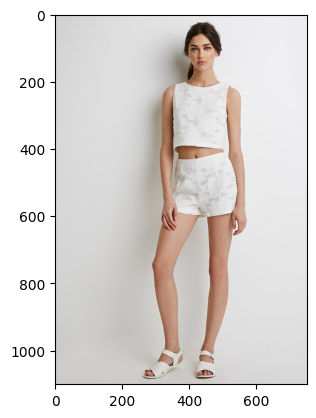

In [ ]:
import torchvision.transforms as transforms
import time

model = ARCTIC(config.image_code_dim, vocab, config.word_dim, config.attention_dim, config.hidden_size, config.num_layers)
model.load_state_dict(torch.load(os.path.join(ckpt_path, f"best_ARCTIC_sf{sf_str}.pth")))

model = model.to(device)
model.eval()

with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}

with open(os.path.join(output_folder, 'test_data.json'), 'r') as t:
    test = json.load(t)
img = Image.open(test['IMAGES'][0]).convert('RGB')
plt.imshow(img)
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
img = transform(img).unsqueeze(0)

img = img.to(device)

with torch.no_grad():
    generated_text = model.generate(img, 5, 80)
print("generated text is", generated_text)
for text in generated_text:
    print("decode text is",' '.join([vocab_idx2word[word_idx] for word_idx in text]))
    
print("========================= METEOR, ROUGE-L EVALUATE ==============================")

time_start = time.monotonic()
meteor_score = evaluate_meteor(test_loader, model, config)
time_metric_meteor = time.monotonic()
rouge_l_score = evaluate_Rouge_L(test_loader, model, config)
time_metric_rouge = time.monotonic()

print(f"METEOR: {meteor_score}, metric cost: {time_metric_meteor - time_start}")
print(f"ROUGE-L: {rouge_l_score}, metric cost: {time_metric_rouge - time_metric_meteor}" )
